In [18]:
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.downloader import download
import re

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras.layers import Embedding

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from gensim.models import Word2Vec

In [19]:
import nltk
print(nltk.data.find('corpora/wordnet.zip'))

C:\Users\HP\AppData\Roaming\nltk_data\corpora\wordnet.zip


In [20]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = r'C:\\Users\\HP\\AppData\\Roaming\\nltk_data\\corpora\\wordnet.zip'
extraction_path = r'C:\\Users\\HP\\AppData\\Roaming\\nltk_data\\corpora\\wordnet'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Unzipping complete!")

Unzipping complete!


In [21]:
data = { 'comments': ['Social media can help people connect with others, learn, and be creative',
         ' It can also be a way to manage social anxiety and access support',        
         'Social media can also be a way for businesses to promote their products',
         'Social media can lead to addiction, isolation, and poor mental health',
         'It can also expose people to inappropriate content, cyberbullying, and privacy and data breaches',
         'Social media can also lead to unhealthy comparisons and unrealistic body image'],
        'class': [1,1,1,0,0,0]
        }
df = pd.DataFrame(data=data , columns=[ 'comments','class'])
df

,comments,class
0,Social media can help people connect with othe...,1
1,It can also be a way to manage social anxiety...,1
2,Social media can also be a way for businesses ...,1
3,"Social media can lead to addiction, isolation,...",0
4,It can also expose people to inappropriate con...,0
5,Social media can also lead to unhealthy compar...,0


In [28]:
stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()
def clean_data(x):
    x_text = BeautifulSoup(x).getText()
    x_text = x_text.lower()
    x_text = re.sub('[^A-Za-z]',' ',x_text)
    x_tokens = word_tokenize(x_text)
    x_tokens = [word for word in x_tokens if word not in stop_words]
    x_tokens = [lemm.lemmatize(word) for word in x_tokens]
    return x_tokens

In [23]:
import nltk
nltk.data.path.append(r'C:\\Users\\HP\\AppData\\Roaming\\nltk_data')  # Replace with your path


In [29]:
df['token'] = df['comments'].apply(clean_data)
df

,comments,class,token
0,Social media can help people connect with othe...,1,"[social, medium, help, people, connect, others..."
1,It can also be a way to manage social anxiety...,1,"[also, way, manage, social, anxiety, access, s..."
2,Social media can also be a way for businesses ...,1,"[social, medium, also, way, business, promote,..."
3,"Social media can lead to addiction, isolation,...",0,"[social, medium, lead, addiction, isolation, p..."
4,It can also expose people to inappropriate con...,0,"[also, expose, people, inappropriate, content,..."
5,Social media can also lead to unhealthy compar...,0,"[social, medium, also, lead, unhealthy, compar..."


In [30]:
w2v_model = Word2Vec(df['token'],min_count=1)
print(w2v_model)
print(w2v_model.wv.key_to_index.keys()) #vocabulary

Word2Vec<vocab=35, vector_size=100, alpha=0.025>
dict_keys(['social', 'medium', 'also', 'way', 'people', 'lead', 'data', 'support', 'unrealistic', 'help', 'comparison', 'connect', 'others', 'learn', 'creative', 'unhealthy', 'breach', 'manage', 'anxiety', 'access', 'business', 'privacy', 'promote', 'product', 'body', 'addiction', 'isolation', 'poor', 'mental', 'health', 'expose', 'inappropriate', 'content', 'cyberbullying', 'image'])


In [31]:
w2v_model.wv.most_similar('social')

[('breach', 0.21917442977428436),
 ('help', 0.21605129539966583),
 ('mental', 0.19524669647216797),
 ('expose', 0.15195180475711823),
 ('image', 0.14181889593601227),
 ('content', 0.10894813388586044),
 ('poor', 0.09953270852565765),
 ('others', 0.09343398362398148),
 ('support', 0.0931793674826622),
 ('business', 0.08463030308485031)]

In [32]:
len(set(df['comments'].str.cat(sep=' ').lower().split()))

44

In [33]:
n = len(set(df['comments'].str.cat(sep=' ').lower().split()))
encoded_ss = [one_hot(sent,n) for sent in df['comments']]
encoded_ss

[[27, 11, 23, 42, 42, 1, 29, 1, 16, 10, 23, 37],
 [26, 23, 31, 23, 5, 31, 42, 34, 27, 40, 10, 36, 11],
 [27, 11, 23, 31, 23, 5, 31, 11, 12, 42, 34, 33, 26],
 [27, 11, 23, 23, 42, 11, 34, 10, 11, 28, 31],
 [26, 23, 31, 13, 42, 42, 15, 7, 24, 10, 42, 10, 11, 22],
 [27, 11, 23, 31, 23, 42, 4, 38, 10, 33, 40, 41]]

In [34]:
length = len(max(encoded_ss))
padding = pad_sequences(encoded_ss,maxlen=length,padding='pre')
padding

array([[27, 11, 23, 42, 42,  1, 29,  1, 16, 10, 23, 37],
       [23, 31, 23,  5, 31, 42, 34, 27, 40, 10, 36, 11],
       [11, 23, 31, 23,  5, 31, 11, 12, 42, 34, 33, 26],
       [ 0, 27, 11, 23, 23, 42, 11, 34, 10, 11, 28, 31],
       [31, 13, 42, 42, 15,  7, 24, 10, 42, 10, 11, 22],
       [27, 11, 23, 31, 23, 42,  4, 38, 10, 33, 40, 41]])

In [35]:
seq_model = Sequential()
seq_model.add(Embedding(n,8,input_length=length))
seq_model.add(Flatten())
seq_model.add(Dense(1,activation='sigmoid'))
seq_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
seq_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
seq_model.fit(padding,df['class'],epochs=10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 0.7041
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3333 - loss: 0.7007
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5000 - loss: 0.6972
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8333 - loss: 0.6938
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8333 - loss: 0.6904
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8333 - loss: 0.6869
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8333 - loss: 0.6836
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8333 - loss: 0.6802
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8333 - loss: 0.6768
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8333 - loss: 0.6734


In [38]:
loss, accuracy = seq_model.evaluate(padding,df['class'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8333 - loss: 0.6701


In [39]:
predictions = seq_model.predict(padding)
y_pred = (predictions>0.5).astype(int)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


array([[1],
       [1],
       [1],
       [0],
       [1],
       [0]])

In [40]:
new_sentences = ['Building Relationships and connect, also to promote the products','Social media can cause sleeplessness,security breach']

new_encoded_ss = [one_hot(sent,n ) for sent in new_sentences]
new_encoded_ss

[[37, 18, 10, 1, 31, 42, 34, 3, 26], [27, 11, 23, 8, 33, 37, 2]]

In [41]:
new_padding = pad_sequences(new_encoded_ss ,maxlen=length,padding='pre')
new_padding

array([[ 0,  0,  0, 37, 18, 10,  1, 31, 42, 34,  3, 26],
       [ 0,  0,  0,  0,  0, 27, 11, 23,  8, 33, 37,  2]])

In [42]:
predictions = seq_model.predict(new_padding)
y_pred = (predictions>0.5).astype(int)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


array([[0],
       [1]])

In [43]:
for dirname, _, filenames in os.walk('Data/twitter'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [47]:
data = pd.read_csv('../Data/twitter_data.csv')
df = pd.DataFrame(data)
df.head(5)

,tweetID,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweetID        75682 non-null  int64 
 1   entity         75682 non-null  object
 2   sentiment      75682 non-null  object
 3   tweet_content  74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [49]:
df.isna().sum()

tweetID            0
entity             0
sentiment          0
tweet_content    686
dtype: int64

In [50]:
df.dropna(inplace=True)

In [51]:
stop_words = set(stopwords.words('english'))
word_lemm = WordNetLemmatizer()
def preprocess_data(x):
    x_text = BeautifulSoup(x).getText()   
    x_lower = x_text.lower()
    x_spl = re.sub("[^a-zA-Z]", " ", x_lower)  
    x_tokens = word_tokenize(x_spl)
    x_words = [w for w in x_tokens if not w in stop_words] 
    return x_words  

In [52]:
def preprocess_sent(data): 
    raw_sent = nltk.sent_tokenize(data.strip())        
    sentences = [preprocess_data(sent) for sent in raw_sent if len(sent) > 0]    
    return sentences

In [53]:
sentence = []
for tweets in df['tweet_content']:   
    sentence += preprocess_sent(tweets) 

In [54]:
w2v_model = Word2Vec(sentence)

In [55]:
w2v_model.init_sims(replace=True)

In [56]:
model_name = '250features_40minwords_20context'
w2v_model.save(model_name)

In [57]:
w2v_model.wv.most_similar('borders')

[('daniel', 0.9884946346282959),
 ('enthusiasm', 0.9879840016365051),
 ('principal', 0.985912561416626),
 ('ayy', 0.9854103326797485),
 ('colour', 0.9846529960632324),
 ('cuckolding', 0.9842767715454102),
 ('ausforceg', 0.9841505885124207),
 ('esomchi', 0.9836286902427673),
 ('manoranjan', 0.9836180806159973),
 ('credible', 0.9830668568611145)]

In [58]:
sample = df['tweet_content'][0]
print('Sample1')
print('Original:',df['tweet_content'][0])
print('\nProcessed Sentence:',preprocess_sent(sample))

sample = df['tweet_content'][6]
print('\nSample2')
print('Original:',df['tweet_content'][6])
print('\nProcessed Sentence:',preprocess_sent(sample))
print('\nProcessed Sentence after removing Empty values:')
filtered_data = [sent for sent in preprocess_sent(sample) if len(sent) > 0]
filtered_data

Sample1
Original: im getting on borderlands and i will murder you all ,

Processed Sentence: [['im', 'getting', 'borderlands', 'murder']]

Sample2
Original: So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg

Processed Sentence: [['spent', 'hours', 'making', 'something', 'fun'], [], [], ['know', 'huge', 'borderlands', 'fan', 'maya', 'one', 'favorite', 'characters'], ['decided', 'make', 'wallpaper', 'pc'], [], ['original', 'image', 'versus', 'creation', 'made', 'enjoy'], ['pic', 'twitter', 'com', 'mlsi', 'wf', 'jg']]

Processed Sentence after removing Empty values:


[['spent', 'hours', 'making', 'something', 'fun'],
 ['know',
  'huge',
  'borderlands',
  'fan',
  'maya',
  'one',
  'favorite',
  'characters'],
 ['decided', 'make', 'wallpaper', 'pc'],
 ['original', 'image', 'versus', 'creation', 'made', 'enjoy'],
 ['pic', 'twitter', 'com', 'mlsi', 'wf', 'jg']]

In [59]:
df['words'] = df['tweet_content'].apply(preprocess_data)

In [60]:
def getavgvec(words, model, vector_dim):
   
    featureVec = np.zeros((vector_dim,),dtype='float32')
   
    number_of_words = 0.
    
    index2word_set = set(model.wv.index_to_key)
        
    for word in words:
        if word in index2word_set: 
            number_of_words = number_of_words + 1.
            featureVec = np.add(featureVec,model.wv.get_vector(word))
    
    featureVec = np.divide(featureVec,number_of_words) #average
    return featureVec 

In [61]:
df['avg_vec'] = df['words'].apply(lambda x: getavgvec(words=x,model=w2v_model,vector_dim=w2v_model.vector_size))

In [62]:
df.head(5)

,tweetID,entity,sentiment,tweet_content,words,avg_vec
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,"[im, getting, borderlands, murder]","[-0.07200437, 0.015132289, 0.059659194, 0.1389..."
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,"[coming, borders, kill]","[0.039882332, -0.036487717, 0.022603517, 0.124..."
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,"[im, getting, borderlands, kill]","[-0.051914316, 0.008686717, 0.051016703, 0.158..."
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,"[im, coming, borderlands, murder]","[-0.05215894, 0.0056940387, 0.062452454, 0.101..."
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,"[im, getting, borderlands, murder]","[-0.07200437, 0.015132289, 0.059659194, 0.1389..."


In [63]:
avg_feature_vec = np.array(list(df['avg_vec']))
avg_feature_vec = np.nan_to_num(avg_feature_vec)
np.isnan(avg_feature_vec).any()

False

In [65]:
encoder = LabelEncoder()
df['target_encoded'] = encoder.fit_transform( df['sentiment'])

In [67]:
from sklearn.model_selection import train_test_split
X = avg_feature_vec
y = df["target_encoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [68]:
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [69]:
y_pred = rfc.predict(X_test)

In [70]:
print('Accuracy:',accuracy_score(y_test,y_pred))
print('Matthews Coeff:', matthews_corrcoef(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.7747333333333334
Matthews Coeff: 0.6969084981674474
              precision    recall  f1-score   support

           0       0.88      0.60      0.71      2666
           1       0.77      0.86      0.81      4464
           2       0.83      0.74      0.78      3706
           3       0.71      0.83      0.76      4164

    accuracy                           0.77     15000
   macro avg       0.80      0.76      0.77     15000
weighted avg       0.79      0.77      0.77     15000



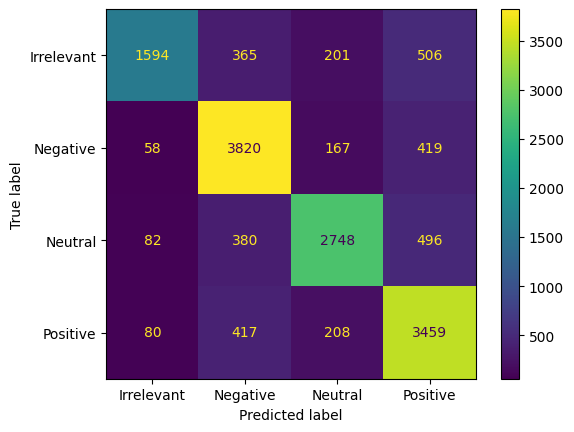

In [71]:
c_mat = confusion_matrix(y_test,y_pred)
display = ConfusionMatrixDisplay(c_mat,display_labels=encoder.inverse_transform(rfc.classes_))
display.plot()